# Jedgment Summarization



## 安裝套件


In [16]:
# ! pip install transformers
# ! pip install datasets
# ! pip install torcheval
# ! pip install scikit-learn
# ! pip install torch
# ! pip install pytorch-ignite
# ! pip install ipywidgets
# ! pip install jieba

In [17]:
import transformers
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm
from ignite.metrics import Rouge
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import jieba
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## 超參數
 - 學習率 (learning rate): 1e-4
 - 訓練輪數 (epochs): 10
 - 優化器 (optimizer): AdamW
 - 批次大小 (batch size): 8
 - 評量指標 (evaluation matrics)Rouge-2

In [18]:
lr = 3e-5
epochs = 10
train_batch_size = 1
validation_batch_size = 1
test_batch_size = 1
random_seed = 42
# max_length = 512
output_length = 512
window_size = 512
stride = 64

# path setting that souldn't be changed
tokenizer_path = "./saved_tokenizer"
dataset_path = "./train.xlsx"
test_dataset_path = './test.xlsx'
model_path = "./saved_model"

## 載入BART模型
 - 使用huggingface裝載模型的架構、參數和tokenizer
 - 保存在路徑./cache/中
 - 用.to(device)把模型裝載入訓練設備(GPU)
 - 使用的 tokenizer 請儲存到指定路徑

In [19]:
checkpoint = "IDEA-CCNL/Randeng-BART-139M-SUMMARY"
# checkpoint = "IDEA-CCNL/Randeng-T5-77M-MultiTask-Chinese"
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint, cache_dir="./cache/").to(device)
tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir="./cache/", model_max_length=512)
tokenizer.save_pretrained(tokenizer_path)

('./saved_tokenizer\\tokenizer_config.json',
 './saved_tokenizer\\special_tokens_map.json',
 './saved_tokenizer\\spiece.model',
 './saved_tokenizer\\added_tokens.json',
 './saved_tokenizer\\tokenizer.json')

In [20]:
optimizer = AdamW(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

## 資料處理
 - 使用 torch.utils.data 中的 Dataset 和 Dataloader 成批次地讀取和預處理資料

In [40]:
import opencc
num_to_chinese = {
    '0': '〇', '1': '一', '2': '二', '3': '三', '4': '四',
    '5': '五', '6': '六', '7': '七', '8': '八', '9': '九',
    '０': '〇', '１': '一', '２': '二', '３': '三', '４': '四',
    '５': '五', '６': '六', '７': '七', '８': '八', '９': '九',
    '○': '〇', ',': '，', '.': '。', ';': '；', ':': '：',
    '!': '！', '?': '？', 
    '⓵': '一', '⓶': '二', '⓷': '三', '⓸': '四', '⓹': '五', '⓺': '六', '⓻': '七', '⓼': '八', '⓽': '九', 
    '➀': '一', '➁': '二', '➂': '三', '➃': '四', '➄': '五', '➅': '六', '➆': '七', '➇': '八', '➈': '九',
    '➊': '一', '➋': '二', '➌': '三', '➍': '四', '➎': '五', '➏': '六', '➐': '七', '➑': '八', '➒': '九',
    '⓿': '〇', '❶': '一', '❷': '二', '❸': '三', '❹': '四', '❺': '五', '❻': '六', '❼': '七', '❽': '八', '❾': '九', 
    '㈠': '一', '㈡': '二', '㈢': '三', '㈣': '四', '㈤': '五', '㈥': '六', '㈦': '七', '㈧': '八', '㈨': '九', 
}

def digit_to_chinese(match):
    return ''.join(num_to_chinese[digit] for digit in match.group())

def clean_text(text):
    if "如下：" in text:
        text = text.split("如下：", 1)[-1]
    
    if "判決如主文" in text:
        text = text.split("判決如主文", 1)[0]
    
    return text


def renoise(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\n','', text)
    text = re.sub(r'[0-9０-９⓵-⓽➀-➈➊-➒❶-❾㈠-㈨○,.;:!?]+', digit_to_chinese, text)
    text = re.sub(r'[^\u4e00-\u9fa5\uff01\uff0c\uff1a\uff1b\uff1f\uff61]', '', text)
    text = clean_text(text)
    converter = opencc.OpenCC('t2s')
    text = converter.convert(text)
    return text

In [33]:
def sliding_window(text, window_size, stride, idx):
    tokens = tokenizer.tokenize(text)
    segments = []
    if idx < 3:
      print(tokens)
    for i in range(0, len(tokens), stride):
        segment = tokens[i:i + window_size]
        if len(segment) < window_size:
          segment += ['<pad>'] * (window_size - len(segment))
        segments.append(tokenizer.convert_tokens_to_string(segment))
        if len(segment) < window_size:
            break
    return segments

In [34]:
def get_tensor(sample):
    # 將模型的輸入和ground truth打包成Tensor
    model_inputs = tokenizer.batch_encode_plus([each["origin_context"] for each in sample], padding=True, truncation=True, return_tensors="pt")
    model_outputs = tokenizer.batch_encode_plus([each["summary"] for each in sample], padding=True, truncation=True, return_tensors="pt")
    return model_inputs["input_ids"].to(device), model_outputs["input_ids"].to(device)

class Legal_Judgment_Dataset(Dataset):
    def __init__(self) -> None:
        super().__init__()
        data_df = pd.read_excel(dataset_path)
        self.data = []
        for index, row in data_df.iterrows():
            origin_context = "summary: " + str(renoise(row['裁判原文']))
            summary = renoise(row['摘要'])
            segments = sliding_window(origin_context, window_size, stride, index)
            for segment in segments:
                self.data.append({"origin_context": segment, "summary": summary})

    def __getitem__(self, index):
        return {"origin_context": self.data[index]['origin_context'], "summary": self.data[index]['summary']}

    def __len__(self):
        return len(self.data)


- 在範例程式中有切分成 train, valid, test，實作上可將全部資料用於 train 與 valid

In [42]:
dataset = Legal_Judgment_Dataset()
train_dataset, untrain_dataset1 = train_test_split(dataset, test_size=0.9, random_state=random_seed)
untrain_dataset2, validation_dataset = train_test_split(untrain_dataset1, test_size=0.005, random_state=random_seed)
summary_train = DataLoader(train_dataset, collate_fn=get_tensor, batch_size=train_batch_size, shuffle=True)
summary_validation = DataLoader(validation_dataset, collate_fn=get_tensor, batch_size=validation_batch_size, shuffle=False)

rouge = Rouge(variants=["L", 2], multiref="best")
print(f"Dataset example: \n{train_dataset[0]} \n{train_dataset[1]} \n{train_dataset[2]}")

['▁su', 'mm', 'ary', ':', '▁主', '文', '上诉', '驳', '回', '理由', '一本', '件', '非常', '上诉', '理由', '称', ':', '按', '刑事', '诉讼', '法', '第一', '一八', '条', '之', '没', '入', '保证金', ',', '系', '因', '被告', '于', '具', '保', '人以', '相当', '金额', '具', '保', '后', '逃', '匿', ',', '所', '给予', '具', '保', '人之', '制裁', ';', '虽', '与', '刑法', '从', '刑', '之', '没收', '有', '别', ',', '但', '此项', '依', '刑事', '诉讼', '法', '所', '为之', '没', '入', '裁定', ',', '依', '同', '法', '第四', '七', '条', '第二', '项规定', ',', '既', '具有', '民事', '强制', '执行', '名义', '之', '效力', ',', '即', '与', '判决', '有', '同一', '效力', ',', '如有', '违背', '法', '令', ',', '自', '得', '提起', '非常', '上诉', '再', '具', '保', '之', '被告', '逃', '匿', '者', ',', '应', '命', '具', '保', '人', '缴纳', '指定', '之', '保证', '金额', ',', '并', '没', '入', '之', ';', '不', '缴纳', '者', ',', '强制', '执行', ';', '保证金', '已', '缴纳', '者', ',', '没', '入', '之', ',', '刑事', '诉讼', '法', '第一', '一八', '条', '定', '有', '明', '文', '是', '没', '入', '具', '保', '人', '缴纳', '之', '保证金', ',', '应以', '被告', '在', '逃', '匿', '中', '为其', '要', '件', '具', '保', '之', '被告', '虽', '曾', '逃', '匿

## 驗證
驗證程式
 - 將驗證資料輸入模型，用Rouge-2評價輸出的效果
 - Rouge的使用方法參考 https://pytorch.org/ignite/generated/ignite.metrics.Rouge.html

In [43]:
def postprocess_output(output):
    output = output.replace("<s>", "").replace("</s>", "")
    output = output.replace(" ", "")
    output = output.replace("<unk>", "").replace("<pad>","")
    return output

In [44]:
def evaluate(model, dataset):
    pbar = tqdm(dataset)
    pbar.set_description(f"Evaluating")
    loss_list = []
    for inputs, targets in pbar:
        loss = model(inputs, labels=targets).loss
        loss_list.append(loss.item())
        pbar.set_postfix(loss = loss.item())
        outputs = [postprocess_output(each) for each in tokenizer.batch_decode(model.generate(inputs,
                                                      max_length=output_length,
                                                      num_beams=3,
                                                      no_repeat_ngram_size=2,
                                                      min_length=150))]
        targets = [postprocess_output(each) for each in tokenizer.batch_decode(targets)]
        print("model generate examples:")
        print(f"output: {outputs}")
        print(f"target: {targets}")
        for out, tar in zip(outputs, targets):
            sentence = " ".join(jieba.cut(out)).split()
            ground_truth = " ".join(jieba.cut(tar)).split()
            for s in sentence:
                rouge.update(([s], [ground_truth]))

    return rouge.compute(), np.mean(np.array(loss_list))


## 訓練
 - 將資料成批次輸入BART模型，並獲取其損失函數數值，隨後計算梯度優化
 - tqdm用來顯示模型的訓練進度

In [45]:
model.to(device)

batch_losses = []

for ep in range(epochs):
    model.train()
    pbar = tqdm(summary_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    for inputs, targets in pbar:
        optimizer.zero_grad()
        loss = model(input_ids=inputs, labels=targets).loss
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss = loss.item())
    torch.save(model, f'{model_path}/ep{ep}.pth')
    model.eval()
    validation_score, validation_loss = evaluate(model, summary_validation)
    scheduler.step(validation_loss)
    print(f"Rouge-2 score on epoch {ep}:", validation_score)

  0%|          | 0/1367 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

model generate examples:
output: ['税捐稽征法第二四三条第一项之判决违背法令二原判决中指称上诉人于一五年八月九日准备程序笔录表示并无进一步证据资料可再就判决发回意旨证明本件交易价格核定完税价格,复于同年九月一日言词辩论当庭提出之行政诉讼补充答辩状一第七页主张已提出银行存档发票,并辅以查得之行情价格已尽查证之举证责任等语,翻异于上诉人一五年九月一一日拟程序之陈述,无法采取云云,惟参照最高法院七三年台上字第一七号判决,更审程序为再审前诉讼程序,为判决不适用法规,且其迳执本院第二次发回判决意意,未顾及比审时仍有相异事实之认定可能,亦属适用行政法二四条法规不当,构成同法第二条第一项规定:一本件事证已明,两造其余主张,应属事实认定,高等行政法院即原审更审判时当可本于职权认事用法,非必受本法院判断拘束而原审判决迳以本案二五年度判字第二八号判例可知,即便本庭已明确表示法律见解,仍可不受本法第三六条法律意见拘']
target: ['依行政诉讼法第一三三条前段规定,行政法院于撤销诉讼,固应依职权调查证据,以期发现真实,当事人并无主观举证责任,然职权调查证据有其限度,仍不免有要件事实不明之情形,而必须决定其不利益结果责任之归属,故当事人仍有客观之举证责任,民事诉讼法第二七七条前段规定:当事人主张有利于己之事实者,就其事实有举证之责任于上述范围内,仍为撤销诉讼所准用行政诉讼法第一三六条参照且课征租税构成要件事实之认定,基于依法行政及规范有利原则,稽征机关就其事实有举证之责任税捐稽征法第一二条之一第四项规定之法理参照,其所提证据必须使法院之心证达到真实确信之程度,始可谓其已尽举证之责,若仅使事实关系陷于真伪不明之状态,行政法院仍应认定该课税要件事实为不存在,而将其不利益归于稽征机关然如果要件事实的本体已经证明存在,仅系其具体的存在情形不明,则仅能假定该具体情形不存在,而不能完全否定其所涉及之要件事实本体之存在,否则无异因噎废食因小失大,有违比例原则,此时即应依职权核定或酌定其具体情形依关税法第二九条规定,从价课征关税之进口货物,其完税价格首应以该进口货物之交易价格,即进口货物由输出国销售至中华民国实付或应付之价格作为计算根据;海关对纳税义务人提出之交易文件或其内容之真实性或正确性存疑,纳税义务人未提出说明或提出说明后,海关仍有合理怀疑者,即视为无法按本条

  0%|          | 0/1367 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

model generate examples:
output: ['税捐稽征法第二六条第二项规定之退还溢缴税款请求权,系纳税义务人迟误行政救济期限后,法律特别赋予之程序重开权利,依行政诉讼法第一三三条第一项规定,法院应依职权调查证据,尽可能在待证事实已明时始为确实之事实,不得再为具体事实之认定,此见行政法院审理准备程序之结果,并经本院一四年度台上字第一七号判例,经核于案发时既已明确表示法律见解,高等行政院更审时,如有相异事实认定可能,仍可不受该院理论见解拘束准此,原审更一审判决认为本案银行存档发票及信用状不足以作为计算完税价格之根据,是证据资料可再就判决发回意旨证明本件交易价格核定完税率价格,复于同年九月一日言词辩论当庭提出之行政诉补充答辩状一第七页主张已提出银行存款存挡发票并辅以查得之行情价,已尽查证之举证责任等语,翻异于上诉人之请求,无法采取云云,惟参照最高法院七三年台字第二八号判决,更为审前诉讼程序,为判决不适用法规,且其迳执本款第二次发交判决意意,未顾及更审判时仍有相异事实者,亦属适用同法二四三条之首项之判决违背法令']
target: ['依行政诉讼法第一三三条前段规定,行政法院于撤销诉讼,固应依职权调查证据,以期发现真实,当事人并无主观举证责任,然职权调查证据有其限度,仍不免有要件事实不明之情形,而必须决定其不利益结果责任之归属,故当事人仍有客观之举证责任,民事诉讼法第二七七条前段规定:当事人主张有利于己之事实者,就其事实有举证之责任于上述范围内,仍为撤销诉讼所准用行政诉讼法第一三六条参照且课征租税构成要件事实之认定,基于依法行政及规范有利原则,稽征机关就其事实有举证之责任税捐稽征法第一二条之一第四项规定之法理参照,其所提证据必须使法院之心证达到真实确信之程度,始可谓其已尽举证之责,若仅使事实关系陷于真伪不明之状态,行政法院仍应认定该课税要件事实为不存在,而将其不利益归于稽征机关然如果要件事实的本体已经证明存在,仅系其具体的存在情形不明,则仅能假定该具体情形不存在,而不能完全否定其所涉及之要件事实本体之存在,否则无异因噎废食因小失大,有违比例原则,此时即应依职权核定或酌定其具体情形依关税法第二九条规定,从价课征关税之进口货物,其完税价格首应以该进口货物之交易价格,即进口货物由输出国销售至中华民国实付或应付之价格作为计算根据;海关对纳税义务人提出之交易文

  0%|          | 0/1367 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

model generate examples:
output: ['按行政诉讼法第二三八条第二项固规定:于上诉审程序,不得为诉之变更追加或提起反诉惟当事人将撤销诉讼转换为续行确认诉讼,既非增加诉讼之请求,亦无增加事实认定之问题,本于同一行政处分,并无妨碍双方之攻击防御,及诉讼程序之进行,属于声明之减缩,而不属上开规定所指诉人之变更,故即使在法律审之上诉程序亦仍应许为此诉讼类型之转换上诉人以本件原处分于原审辩论终结后已执行完毕即一五年一一月四日,参本院卷,据以减减原声明为确认上诉人之权利,核无不合,先予叙明']
target: ['依行政诉讼法第一三三条前段规定,行政法院于撤销诉讼,固应依职权调查证据,以期发现真实,当事人并无主观举证责任,然职权调查证据有其限度,仍不免有要件事实不明之情形,而必须决定其不利益结果责任之归属,故当事人仍有客观之举证责任,民事诉讼法第二七七条前段规定:当事人主张有利于己之事实者,就其事实有举证之责任于上述范围内,仍为撤销诉讼所准用行政诉讼法第一三六条参照且课征租税构成要件事实之认定,基于依法行政及规范有利原则,稽征机关就其事实有举证之责任税捐稽征法第一二条之一第四项规定之法理参照,其所提证据必须使法院之心证达到真实确信之程度,始可谓其已尽举证之责,若仅使事实关系陷于真伪不明之状态,行政法院仍应认定该课税要件事实为不存在,而将其不利益归于稽征机关然如果要件事实的本体已经证明存在,仅系其具体的存在情形不明,则仅能假定该具体情形不存在,而不能完全否定其所涉及之要件事实本体之存在,否则无异因噎废食因小失大,有违比例原则,此时即应依职权核定或酌定其具体情形依关税法第二九条规定,从价课征关税之进口货物,其完税价格首应以该进口货物之交易价格,即进口货物由输出国销售至中华民国实付或应付之价格作为计算根据;海关对纳税义务人提出之交易文件或其内容之真实性或正确性存疑,纳税义务人未提出说明或提出说明后,海关仍有合理怀疑者,即视为无法按本条规定核估其完税价格,并应依序按照关税法第三一条第三二条第三三条第三四条或第三四条第三三条第三五条规定之标准予以核定即为适例,且纳税义务人既已克尽其提出交易文件及为说明之协力义务,海关原本应负担的举证责任强度证明程度,即无从减轻故海关必须查明纳税义务人申报之进口货物交易价格确属虚伪不实,且提出客观上足以证明其真实交易价格之证据

  0%|          | 0/1367 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

model generate examples:
output: ['按行政诉讼法第二三八条第二项固规定:于上诉审程序,不得为诉之变更追加或提起反诉惟当事人将撤销诉讼转换为续行确认诉讼,既非增加诉讼之请求,亦无增加事实认定之问题,本于同一行政处分,并无妨碍双方之攻击防御,及诉讼程序之进行,属于声明之减缩,而不属上开规定所指诉人之变更,故即使在法律审之上诉程序亦仍应许为此诉讼类型之转换上诉人以本件原处分于原审辩论终结后已执行完毕即一五年一一月四日,参本院卷,据以减减原声明为确认上诉人之诉讼防御权,核无不合,先予叙明']
target: ['依行政诉讼法第一三三条前段规定,行政法院于撤销诉讼,固应依职权调查证据,以期发现真实,当事人并无主观举证责任,然职权调查证据有其限度,仍不免有要件事实不明之情形,而必须决定其不利益结果责任之归属,故当事人仍有客观之举证责任,民事诉讼法第二七七条前段规定:当事人主张有利于己之事实者,就其事实有举证之责任于上述范围内,仍为撤销诉讼所准用行政诉讼法第一三六条参照且课征租税构成要件事实之认定,基于依法行政及规范有利原则,稽征机关就其事实有举证之责任税捐稽征法第一二条之一第四项规定之法理参照,其所提证据必须使法院之心证达到真实确信之程度,始可谓其已尽举证之责,若仅使事实关系陷于真伪不明之状态,行政法院仍应认定该课税要件事实为不存在,而将其不利益归于稽征机关然如果要件事实的本体已经证明存在,仅系其具体的存在情形不明,则仅能假定该具体情形不存在,而不能完全否定其所涉及之要件事实本体之存在,否则无异因噎废食因小失大,有违比例原则,此时即应依职权核定或酌定其具体情形依关税法第二九条规定,从价课征关税之进口货物,其完税价格首应以该进口货物之交易价格,即进口货物由输出国销售至中华民国实付或应付之价格作为计算根据;海关对纳税义务人提出之交易文件或其内容之真实性或正确性存疑,纳税义务人未提出说明或提出说明后,海关仍有合理怀疑者,即视为无法按本条规定核估其完税价格,并应依序按照关税法第三一条第三二条第三三条第三四条或第三四条第三三条第三五条规定之标准予以核定即为适例,且纳税义务人既已克尽其提出交易文件及为说明之协力义务,海关原本应负担的举证责任强度证明程度,即无从减轻故海关必须查明纳税义务人申报之进口货物交易价格确属虚伪不实,且提出客观上足以证明其真实交易价格

  0%|          | 0/1367 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

model generate examples:
output: ['税捐稽征法第二八条第二项规定之退还溢缴税款请求权,系纳税义务人迟误行政救济期限后,法律特别赋予之程序重开权利,依行政诉讼法第一三六条准用民事诉讼程序,于法院最后审理阶段,要件事实存否仍属不明时,固应由法院负担客观举证责任,但由于税务诉讼适用职权探知主义,事实审法院应依职权查明为裁判基础之事实关系,尽可能在待证事实已明时作成实体判决,故必须穷尽调查证据之能事行使阐明权令两造声明证据或自行以个人实际需要为之,最后仍无法对重要事实的存在与否获得确信的心证,始得作为判断之依据']
target: ['依行政诉讼法第一三三条前段规定,行政法院于撤销诉讼,固应依职权调查证据,以期发现真实,当事人并无主观举证责任,然职权调查证据有其限度,仍不免有要件事实不明之情形,而必须决定其不利益结果责任之归属,故当事人仍有客观之举证责任,民事诉讼法第二七七条前段规定:当事人主张有利于己之事实者,就其事实有举证之责任于上述范围内,仍为撤销诉讼所准用行政诉讼法第一三六条参照且课征租税构成要件事实之认定,基于依法行政及规范有利原则,稽征机关就其事实有举证之责任税捐稽征法第一二条之一第四项规定之法理参照,其所提证据必须使法院之心证达到真实确信之程度,始可谓其已尽举证之责,若仅使事实关系陷于真伪不明之状态,行政法院仍应认定该课税要件事实为不存在,而将其不利益归于稽征机关然如果要件事实的本体已经证明存在,仅系其具体的存在情形不明,则仅能假定该具体情形不存在,而不能完全否定其所涉及之要件事实本体之存在,否则无异因噎废食因小失大,有违比例原则,此时即应依职权核定或酌定其具体情形依关税法第二九条规定,从价课征关税之进口货物,其完税价格首应以该进口货物之交易价格,即进口货物由输出国销售至中华民国实付或应付之价格作为计算根据;海关对纳税义务人提出之交易文件或其内容之真实性或正确性存疑,纳税义务人未提出说明或提出说明后,海关仍有合理怀疑者,即视为无法按本条规定核估其完税价格,并应依序按照关税法第三一条第三二条第三三条第三四条或第三四条第三三条第三五条规定之标准予以核定即为适例,且纳税义务人既已克尽其提出交易文件及为说明之协力义务,海关原本应负担的举证责任强度证明程度,即无从减轻故海关必须查明纳税义务人申报之进口货物交易价格确属虚伪不实,且提出客观

  0%|          | 0/1367 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

model generate examples:
output: ['按行政诉讼法第二三八条第二项固规定:于上诉审程序,不得为诉之变更追加或提起反诉惟当事人将撤销诉讼转换为续行确认诉讼,既非增加诉讼之请求,亦无增加事实认定之问题,本于同一行政处分,并无妨碍双方之攻击防御,及诉讼程序之进行,属于声明之减缩,而不属上开规定所指诉人之变更,故即使在法律审之上诉程序亦仍应许为此诉讼类型之转换上诉人以本件原处分于原审辩论终结后已执行完毕即一五年一一月四日,参本院卷,据以减减等语见原判决一审卷第三六页,则原认定上诉人于一五年九月九日准备程序笔录,是否毫无足取,即非无疑,应予驳回']
target: ['依行政诉讼法第一三三条前段规定,行政法院于撤销诉讼,固应依职权调查证据,以期发现真实,当事人并无主观举证责任,然职权调查证据有其限度,仍不免有要件事实不明之情形,而必须决定其不利益结果责任之归属,故当事人仍有客观之举证责任,民事诉讼法第二七七条前段规定:当事人主张有利于己之事实者,就其事实有举证之责任于上述范围内,仍为撤销诉讼所准用行政诉讼法第一三六条参照且课征租税构成要件事实之认定,基于依法行政及规范有利原则,稽征机关就其事实有举证之责任税捐稽征法第一二条之一第四项规定之法理参照,其所提证据必须使法院之心证达到真实确信之程度,始可谓其已尽举证之责,若仅使事实关系陷于真伪不明之状态,行政法院仍应认定该课税要件事实为不存在,而将其不利益归于稽征机关然如果要件事实的本体已经证明存在,仅系其具体的存在情形不明,则仅能假定该具体情形不存在,而不能完全否定其所涉及之要件事实本体之存在,否则无异因噎废食因小失大,有违比例原则,此时即应依职权核定或酌定其具体情形依关税法第二九条规定,从价课征关税之进口货物,其完税价格首应以该进口货物之交易价格,即进口货物由输出国销售至中华民国实付或应付之价格作为计算根据;海关对纳税义务人提出之交易文件或其内容之真实性或正确性存疑,纳税义务人未提出说明或提出说明后,海关仍有合理怀疑者,即视为无法按本条规定核估其完税价格,并应依序按照关税法第三一条第三二条第三三条第三四条或第三四条第三三条第三五条规定之标准予以核定即为适例,且纳税义务人既已克尽其提出交易文件及为说明之协力义务,海关原本应负担的举证责任强度证明程度,即无从减轻故海关必须查明纳税义务人申报之进口货物交

  0%|          | 0/1367 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

model generate examples:
output: ['税捐稽征法第二八条第二项规定之退还溢缴税款请求权,系纳税义务人迟误行政救济期限后,法律特别赋予之程序重开权利,依行政诉讼法第一三六条准用民事庭审理前之经验法则,经本院九四年台上字第一九九八号著有判例可参而民事诉讼上之规范有利原则,乃宪法第一七三条之一第一项所明定应适用之行政程序法,其效力不受当事人争执及当事人辩论之限度内,法院自应依职权查明为裁判基础之事实关系,尽可能在待证事实已明时作成实体判决,故必须穷尽调查证据之能事行使阐明权令两造声明证据足以证明系争税事实之存在,始为适法倘非出于当事人之适格,仍无疑使法院之心证达到真实确信之程度,因当事人已为客观举证责任,而无法对要件事实的存在与否获得确信的心证,将使审判程序空洞化,破坏直接审理与言词审理原则']
target: ['依行政诉讼法第一三三条前段规定,行政法院于撤销诉讼,固应依职权调查证据,以期发现真实,当事人并无主观举证责任,然职权调查证据有其限度,仍不免有要件事实不明之情形,而必须决定其不利益结果责任之归属,故当事人仍有客观之举证责任,民事诉讼法第二七七条前段规定:当事人主张有利于己之事实者,就其事实有举证之责任于上述范围内,仍为撤销诉讼所准用行政诉讼法第一三六条参照且课征租税构成要件事实之认定,基于依法行政及规范有利原则,稽征机关就其事实有举证之责任税捐稽征法第一二条之一第四项规定之法理参照,其所提证据必须使法院之心证达到真实确信之程度,始可谓其已尽举证之责,若仅使事实关系陷于真伪不明之状态,行政法院仍应认定该课税要件事实为不存在,而将其不利益归于稽征机关然如果要件事实的本体已经证明存在,仅系其具体的存在情形不明,则仅能假定该具体情形不存在,而不能完全否定其所涉及之要件事实本体之存在,否则无异因噎废食因小失大,有违比例原则,此时即应依职权核定或酌定其具体情形依关税法第二九条规定,从价课征关税之进口货物,其完税价格首应以该进口货物之交易价格,即进口货物由输出国销售至中华民国实付或应付之价格作为计算根据;海关对纳税义务人提出之交易文件或其内容之真实性或正确性存疑,纳税义务人未提出说明或提出说明后,海关仍有合理怀疑者,即视为无法按本条规定核估其完税价格,并应依序按照关税法第三一条第三二条第三三条第三四条或第三四条第三三条第三五条规定之标准予以核

  0%|          | 0/1367 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

model generate examples:
output: ['税捐稽征法第二八条第二项规定之退还溢缴税款请求权,系纳税义务人迟误行政救济期限后,法律特别赋予之程序重开权利,依行政诉讼法第一三六条准用民事庭审理前之准备程序,固得为适当,但法律另有规定者,从其规定自然人法人非法人之团体或其他受不起诉处分或被诉人提起诉愿逾三个月不为决定,或延长诉讼期,至发回范围时,始得为之二查一七一至四月份第二次庭长法官联席会议决议参照可知,该诉讼事件于更审前已受理而尚未处分之异议或评定案件,以注册时及本院一三年度台上字第一七二三号判决可资参照查上诉人于一五年一月一九日向中院提起民事诉讼,于原审程序中已详为论述说明,上诉人对上开诉讼案之请求果尔,上诉人对此同意之论点,虽于审判期日已表示异议,然仍无疑使审判程序空洞化,破坏直接审理与言词审理原则,并嫌无据']
target: ['依行政诉讼法第一三三条前段规定,行政法院于撤销诉讼,固应依职权调查证据,以期发现真实,当事人并无主观举证责任,然职权调查证据有其限度,仍不免有要件事实不明之情形,而必须决定其不利益结果责任之归属,故当事人仍有客观之举证责任,民事诉讼法第二七七条前段规定:当事人主张有利于己之事实者,就其事实有举证之责任于上述范围内,仍为撤销诉讼所准用行政诉讼法第一三六条参照且课征租税构成要件事实之认定,基于依法行政及规范有利原则,稽征机关就其事实有举证之责任税捐稽征法第一二条之一第四项规定之法理参照,其所提证据必须使法院之心证达到真实确信之程度,始可谓其已尽举证之责,若仅使事实关系陷于真伪不明之状态,行政法院仍应认定该课税要件事实为不存在,而将其不利益归于稽征机关然如果要件事实的本体已经证明存在,仅系其具体的存在情形不明,则仅能假定该具体情形不存在,而不能完全否定其所涉及之要件事实本体之存在,否则无异因噎废食因小失大,有违比例原则,此时即应依职权核定或酌定其具体情形依关税法第二九条规定,从价课征关税之进口货物,其完税价格首应以该进口货物之交易价格,即进口货物由输出国销售至中华民国实付或应付之价格作为计算根据;海关对纳税义务人提出之交易文件或其内容之真实性或正确性存疑,纳税义务人未提出说明或提出说明后,海关仍有合理怀疑者,即视为无法按本条规定核估其完税价格,并应依序按照关税法第三一条第三二条第三三条第三四条或第三四条第三三条第

  0%|          | 0/1367 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

model generate examples:
output: ['税捐稽征法第二八条第二项规定之退还溢缴税款请求权,系纳税义务人迟误行政救济期限后,法律特别赋予之程序重开权利,依行政诉讼法第一三六条准用民事诉讼法律第二七七条前段规定之规范有利原则,于法院最后审理阶段,要件事实存否仍属不明时,固应由法院依职权查明为裁判基础之事实关系,尽可能在待证事实已明时作成实体判决,故必须穷尽调查证据之能事行使阐明权令两造声明证据或自行自行调查,最后仍无法对重要事实的存在与否获得确信的心证,始得为客观举证责任之分配,如果尚有调查所得之可能,却迳为具体判决之证据,即属率断本件原判决认为:上诉人于一五年一至二月及三至四月份营业税申报,列报系争零税率销售额三,五四二,八七五元及五,二二元,应退税额一七四,四六四元与二四九,五二八,并无不合而原审既已认定是上诉人前述行为系为逃漏税事实,则其上诉意旨主张被上诉人一五年八月一日起诉,违反行政法上义务,主张其就同一事件已详为论述,已有可议']
target: ['依行政诉讼法第一三三条前段规定,行政法院于撤销诉讼,固应依职权调查证据,以期发现真实,当事人并无主观举证责任,然职权调查证据有其限度,仍不免有要件事实不明之情形,而必须决定其不利益结果责任之归属,故当事人仍有客观之举证责任,民事诉讼法第二七七条前段规定:当事人主张有利于己之事实者,就其事实有举证之责任于上述范围内,仍为撤销诉讼所准用行政诉讼法第一三六条参照且课征租税构成要件事实之认定,基于依法行政及规范有利原则,稽征机关就其事实有举证之责任税捐稽征法第一二条之一第四项规定之法理参照,其所提证据必须使法院之心证达到真实确信之程度,始可谓其已尽举证之责,若仅使事实关系陷于真伪不明之状态,行政法院仍应认定该课税要件事实为不存在,而将其不利益归于稽征机关然如果要件事实的本体已经证明存在,仅系其具体的存在情形不明,则仅能假定该具体情形不存在,而不能完全否定其所涉及之要件事实本体之存在,否则无异因噎废食因小失大,有违比例原则,此时即应依职权核定或酌定其具体情形依关税法第二九条规定,从价课征关税之进口货物,其完税价格首应以该进口货物之交易价格,即进口货物由输出国销售至中华民国实付或应付之价格作为计算根据;海关对纳税义务人提出之交易文件或其内容之真实性或正确性存疑,纳税义务人未提出说明或提出说明后,

  0%|          | 0/1367 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

model generate examples:
output: ['税捐稽征法第二八条第二项规定之退还溢缴税款请求权,系纳税义务人迟误行政救济期限后,法律特别赋予之程序重开权利,依行政诉讼法第一三六条准用民事诉讼程序,于法院最后审理阶段,要件事实存否仍属不明时,固应由法院依职权查明为裁判基础之事实关系,尽可能在待证事实已明时作成实体判决,故必须穷尽调查证据之能事行使阐明权令两造声明证据或自行以特定方式公告之,并经法院整理并协议简化争讼者,始得为适法倘法院认为已就该证据进行调查,却未对当事人之主张为合法与否之审查,自应容许当事人于更审程序中提出新诉讼证据请求救济']
target: ['依行政诉讼法第一三三条前段规定,行政法院于撤销诉讼,固应依职权调查证据,以期发现真实,当事人并无主观举证责任,然职权调查证据有其限度,仍不免有要件事实不明之情形,而必须决定其不利益结果责任之归属,故当事人仍有客观之举证责任,民事诉讼法第二七七条前段规定:当事人主张有利于己之事实者,就其事实有举证之责任于上述范围内,仍为撤销诉讼所准用行政诉讼法第一三六条参照且课征租税构成要件事实之认定,基于依法行政及规范有利原则,稽征机关就其事实有举证之责任税捐稽征法第一二条之一第四项规定之法理参照,其所提证据必须使法院之心证达到真实确信之程度,始可谓其已尽举证之责,若仅使事实关系陷于真伪不明之状态,行政法院仍应认定该课税要件事实为不存在,而将其不利益归于稽征机关然如果要件事实的本体已经证明存在,仅系其具体的存在情形不明,则仅能假定该具体情形不存在,而不能完全否定其所涉及之要件事实本体之存在,否则无异因噎废食因小失大,有违比例原则,此时即应依职权核定或酌定其具体情形依关税法第二九条规定,从价课征关税之进口货物,其完税价格首应以该进口货物之交易价格,即进口货物由输出国销售至中华民国实付或应付之价格作为计算根据;海关对纳税义务人提出之交易文件或其内容之真实性或正确性存疑,纳税义务人未提出说明或提出说明后,海关仍有合理怀疑者,即视为无法按本条规定核估其完税价格,并应依序按照关税法第三一条第三二条第三三条第三四条或第三四条第三三条第三五条规定之标准予以核定即为适例,且纳税义务人既已克尽其提出交易文件及为说明之协力义务,海关原本应负担的举证责任强度证明程度,即无从减轻故海关必须查明纳税义务人申报之进口货物交易价

## 測試
- 使用以下程式接跑 test data

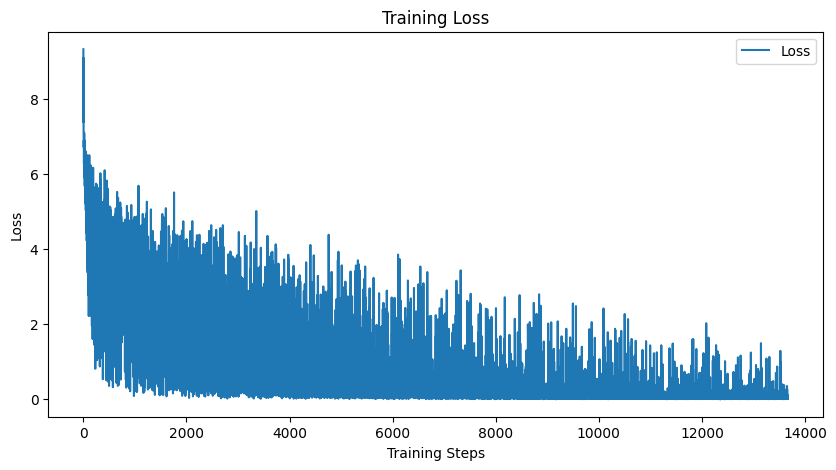

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(batch_losses, label='Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [47]:
def test(model, test_dataset, test_batch_size):
    model.eval()
    test_dataset['摘要'] = None
    pbar = tqdm(range(0, len(test_dataset), test_batch_size), desc="Testing")

    for start_idx in pbar:
        end_idx = min(start_idx + test_batch_size, len(test_dataset))
        batch = test_dataset.iloc[start_idx:end_idx]
        ori_data = ["summary: " + str(row["裁判原文"]) for _, row in batch.iterrows()]

        inputs = tokenizer(ori_data, padding=True, truncation=True, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs_context = model.generate(**inputs, max_length=output_length, num_beams=3, no_repeat_ngram_size=2, min_length=150)

        outputs = [postprocess_output(tokenizer.decode(output, skip_special_tokens=True)) for output in outputs_context]

        for idx, output in zip(batch.index, outputs):
            test_dataset.at[idx, "摘要"] = output

    return test_dataset

In [48]:
test_dataset = pd.read_excel(test_dataset_path)
result_data = test(model, test_dataset, test_batch_size)
converter = opencc.OpenCC('s2t')
result_data = result_data.applymap(lambda x: converter.convert(x) if isinstance(x, str) else x)
result_data.to_excel("result.xlsx", index=False)

Testing:   0%|          | 0/59 [00:00<?, ?it/s]

C:\Users\user\AppData\Local\Temp\ipykernel_9612\3384859694.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result_data = result_data.applymap(lambda x: converter.convert(x) if isinstance(x, str) else x)
